#  STAT 4984 Final Project: Music Genre Classification by Daniel Kim

# Data Prep



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/My Drive/Data/images_original/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
genre_nums = {"blues":0,
          "classical":1,
            "country":2,
              "disco":3,
             "hiphop":4,
               "jazz":5,
              "metal":6,
                "pop":7,
             "reggae":8,
               "rock":9}

In [ ]:
image_genre_labels = []
image_genre_label_nums = []
image_paths = []

for genre in genre_nums:
  for i in range(0,100): 
    # avoid reading missing data
    if not(genre == "jazz" and i == 54):
      imageNumber = str(i).zfill(2)    
      img_path = genre + "/" + genre + "000" + imageNumber + ".png"
      image_paths.append(img_path)
      image_genre_label_nums.append(genre_nums[genre])
      image_genre_labels.append(genre)

In [ ]:
import pandas as pd

df = pd.DataFrame({"imagePath":image_paths, "genreCode":image_genre_label_nums, "genreLabel":image_genre_labels})
display(df.head())

,imagePath,genreCode,genreLabel
0,blues/blues00000.png,0,blues
1,blues/blues00001.png,0,blues
2,blues/blues00002.png,0,blues
3,blues/blues00003.png,0,blues
4,blues/blues00004.png,0,blues


In [ ]:
audioImageGenresFilePath = "/content/drive/My Drive/Data/audioImageGenres.csv"
df.to_csv(audioImageGenresFilePath, index=False)

In [ ]:
# reference: https://www.youtube.com/watch?v=ZoZHd0Zm3RY&ab_channel=AladdinPersson

import os
import torch
from torch.utils.data import Dataset
from skimage import io

class MusicGenreDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
    
    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset = MusicGenreDataset(csv_file = audioImageGenresFilePath, root_dir = dir, transform = transforms.ToTensor())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train, test = torch.utils.data.random_split(dataset, [train_size, test_size])
trainset = DataLoader(dataset=train, batch_size=10, shuffle=True)
testset = DataLoader(dataset=test, batch_size=10, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
import torch.optim as optim

# Model Building

Define a CNN with the following architecture:

1. Input layer (432, 288, 4)
2. Convolutional layer (CONV 1) with 16 2*2 filters and stride 2 and no zero-padding.
3. Pooling layer (POOL 1) with window size 2*2 and stride 2.
4. Convolutional layer (CONV 2) with 32 2*2 filters and stride 1 and no zero-padding.
5. Pooling layer (POOL 2) with window size 2*2 and stride 2.
6. Convolutional layer (CONV 3) with 64 2*2 filters and stride 1 and no zero-padding.
7. Fully connected layer with 128 neurons.
8. Output layer with 10 neurons.

Sizes of the output tensors for CONV 1, CONV 2, CONV 3, POOL 1, and POOL 2 below:

**CONV 1:**  
W = 432, H = 288, K = 2, P = 0, S = 2  
W0 = (W - K + 2$\times$P)/S + 1 = (432 - 2 + 2$\times$0)/2 + 1 = 216.  
H0 = (H - K + 2$\times$P)/S + 1 = (288 - 2 + 2$\times$0)/2 + 1 = 144.  
The output tensor size is 144x216.  

**POOL 1:** 
W = 216, H = 144, K = 2, S = 2  
W0 = (W - K)/S + 1 = (216 - 2)/2 + 1 = 108.  
H0 = (H - K)/S + 1 = (144 - 2)/2 + 1 = 72.  
The output tensor size is 72x108.  

**CONV 2:**  
W = 108, H = 72, K = 2, P = 0, S = 1  
W0 = (W - K + 2$\times$P)/S + 1 = (108 - 2 + 2$\times$0)/1 + 1 = 107.  
H0 = (H - K + 2$\times$P)/S + 1 = (72 - 2 + 2$\times$0)/1 + 1 = 71.  
The output tensor size is 71x107.  

**POOL 2:**  
W = 107, H = 71, K = 2, S = 2  
W0 = (W - K)/S + 1 = (107 - 2)/2 + 1 = 53.  
H0 = (H - K)/S + 1 = (71 - 2)/2 + 1 = 35.  
The output tensor size is 35x53.  

**CONV 3:**  
W = 53, H = 35, K = 2, P = 0, S = 1  
W0 = (W - K + 2$\times$P)/S + 1 = (53 - 2 + 2$\times$0)/1 + 1 = 52.  
H0 = (H - K + 2$\times$P)/S + 1 = (35 - 2 + 2$\times$0)/1 + 1 = 34.  
The output tensor size is 34x52.  

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1)
        self.pool1  = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool2  = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(34*52*64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.drop1 = nn.Dropout(0.7)

    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = F.relu(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = F.relu(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.drop1(y)
        y = F.relu(y)
        y = self.fc2(y)
        return y

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5().to(device)
print(net)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

LeNet5(
  (conv1): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=113152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (drop1): Dropout(p=0.7, inplace=False)
)


In [ ]:
epochs = 300
for epoch in range(epochs): 
  for data in trainset:  
    X, y = data
    X = X.to(device)
    y = y.to(device) 
    net.zero_grad()  
    output = net(X)  
    loss = loss_criterion(output, y)  

    # Backpropergation 
    loss.backward()  
    optimizer.step()  
  print(loss) 

tensor(2.3037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3242, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3526, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2766, device='cuda:0', grad_fn=

# Testing and Training Accuracy

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        output = net(X)
        
        for idx, i in enumerate(output):
          if torch.argmax(i) == y[idx]:
            correct += 1
          total += 1

print("Test Accuracy: ", round(correct/total, 2))

Test Accuracy:  0.34


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        output = net(X)
        
        for idx, i in enumerate(output):
          if torch.argmax(i) == y[idx]:
            correct += 1
          total += 1

print("Train Accuracy: ", round(correct/total, 2))

Train Accuracy:  0.96


# Confusion Matrix

In [ ]:
# reference: https://androidkt.com/pytorch-confusion-matrix-for-multi-class-image-classification/

y_true = []
y_pred = []

for data in testset:
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
  outputs=net(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

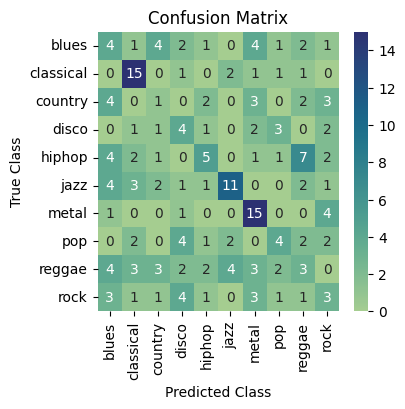

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(dataframe, annot=True, cbar=True, cmap="crest", fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()